In [149]:
# %pip install openpyxl matplotlib pandas micropip statsmodels scikit-learn

In [150]:
# 1) Installa engine Excel e Matplotlib
import micropip
await micropip.install(["openpyxl", "matplotlib"])

# 2) Librerie
import pandas as pd
import matplotlib.pyplot as plt

# Un'occhiata rapida al dataset

In [151]:
# 3) Leggi il foglio “CAUSALI A MANO” (header sulla seconda riga)
df = pd.read_excel(
    "ANALISI CAUSALI OEE.xlsx",
    sheet_name="CAUSALI A MANO",
    header=1
)

# 4) Vediamo l'head
print("Sheet caricato:", df.shape, "righe×colonne")
df.head()

Sheet caricato: (1088, 11) righe×colonne


,Unnamed: 0,GG,SETT,GIORNO,POSTAZIONE,OPERATORE,CAUSALE,TEMPO ANNOTATO [min],DIFF,(FORSE) COMPRESO IN,CAUSALI POSTAZIONE
0,NaN,lun,6,2025-02-03,100,719,RIFORNIMENTO MORSETTIERA,15,NaN,NaN,NaN
1,NaN,lun,6,2025-02-03,100,714,PREPARAZIONE SCHEDE E CASSA NUOVA,15,NaN,5700,NaN
2,NaN,lun,6,2025-02-03,110,714,RIBATTUTO RACCORDO MINIFGX,10,NaN,NaN,NaN
3,NaN,lun,6,2025-02-03,110,714,RUBINETTO MANOMETRO DIFETTATO,10,NaN,NaN,NaN
4,NaN,lun,6,2025-02-03,110,59,NON ARRIVA CORRENTE,30,NaN,NaN,NaN


In [152]:
# 5) Informazioni generali
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            0 non-null      float64       
 1   GG                    1088 non-null   object        
 2   SETT                  1088 non-null   int64         
 3   GIORNO                1088 non-null   datetime64[ns]
 4   POSTAZIONE            1088 non-null   int64         
 5   OPERATORE             1088 non-null   int64         
 6   CAUSALE               1088 non-null   object        
 7   TEMPO ANNOTATO [min]  1067 non-null   object        
 8   DIFF                  2 non-null      float64       
 9   (FORSE) COMPRESO IN   77 non-null     object        
 10  CAUSALI POSTAZIONE    4 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 93.6+ KB


In [153]:
# 6) Statistiche descrittive su “TEMPO ANNOTATO [min]”
df['CAUSALE'].describe()

count                   1088
unique                   203
top       RECUPERO MATERIALE
freq                     170
Name: CAUSALE, dtype: object

In [154]:
# --- CELL: pulizia colonne e conversione in numerico ---

# verifica prima come si chiamano esattamente le colonne
print(df.columns.tolist())

# rimuovo spazi bianchi per sicurezza
df.columns = df.columns.str.strip()

# converto in numerico (tutto ciò che non si riesce a convertire diventa NaN)
df['TEMPO ANNOTATO [min]'] = pd.to_numeric(df['TEMPO ANNOTATO [min]'], errors='coerce')

# se vuoi, sostituisci NaN con zero
df['TEMPO ANNOTATO [min]'] = df['TEMPO ANNOTATO [min]'].fillna(0).astype(int)

# controlla il tipo
print(df['TEMPO ANNOTATO [min]'].dtype)

['Unnamed: 0', 'GG', 'SETT', 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]', 'DIFF', '(FORSE) COMPRESO IN', 'CAUSALI POSTAZIONE']
int64


# Pareto analysis

## 80/20 chart

In [155]:
# 7) Tempo totale per ciascuna CAUSALE
cause_summary = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)
cause_summary

CAUSALE
RECUPERO MATERIALE                                4450
AIUTATO                                           2265
ADDESTRAMENTO                                     1915
ASPIRAZIONE CENTRALINE E SISTEMAZIONE CARRELLI    1885
COLLOQUIO                                         1430
                                                  ... 
SOSTITUZIONE BOBINA                                  5
SOSTITUZIONE BASETTA                                 5
TARATURA POMPA A MANO                                5
SISTEMAZIONE CAVI BOBINE                             0
SCOLARE OLIO                                         0
Name: TEMPO ANNOTATO [min], Length: 203, dtype: int64

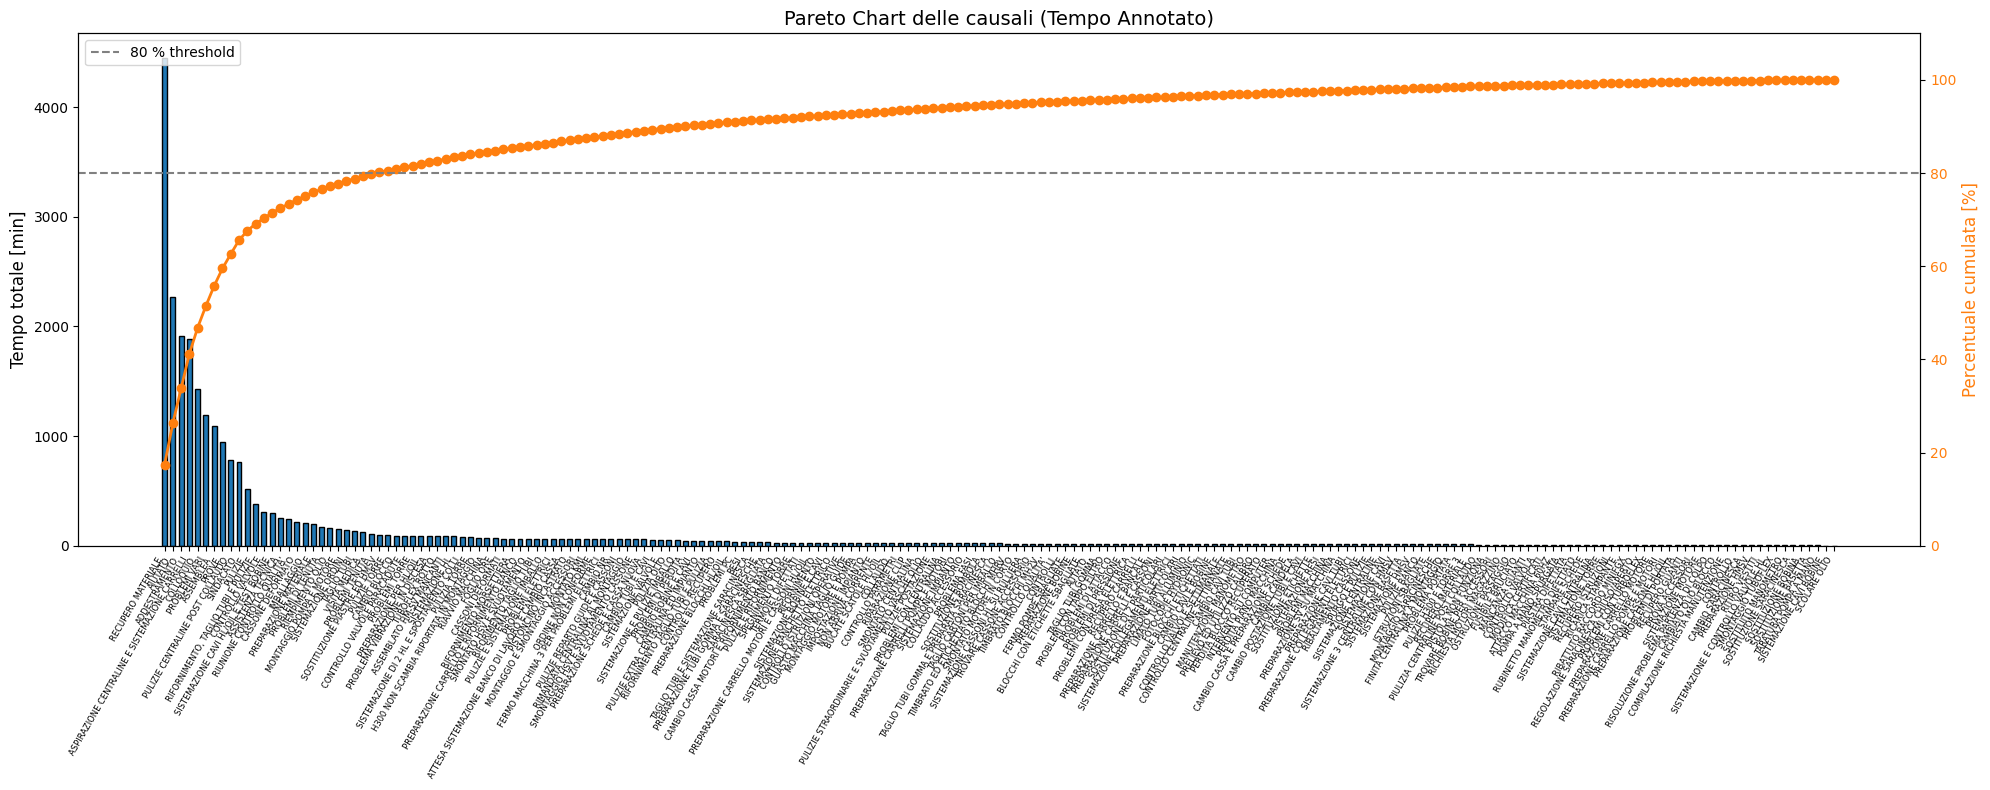

In [156]:
# --- PARETO CHART delle causali ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Copia df e normalizza i nomi colonne
df_p = df.copy()
df_p.columns = (
    df_p.columns
         .str.strip()
         .str.upper()
         .str.replace(r'[\s\[\]]+', '_', regex=True)
         .str.strip('_')
)

# 2) Forza TEMPO_ANNOTATO_MIN a numerico
df_p['TEMPO_ANNOTATO_MIN'] = pd.to_numeric(df_p['TEMPO_ANNOTATO_MIN'], errors='coerce').fillna(0)

# 3) Raggruppa e ordina tutte le causali
grp = (df_p
       .groupby('CAUSALE', observed=True)['TEMPO_ANNOTATO_MIN']
       .sum()
       .sort_values(ascending=False))

# 4) Calcola cumulata percentuale
cum = (grp / grp.sum() * 100).cumsum()

# 5) Prepara le posizioni
x = np.arange(len(grp))
width = 0.6

# 6) Disegna
fig, ax1 = plt.subplots(figsize=(20,8))  # figura più larga ed alta

# barre
ax1.bar(x, grp.values, width=width, edgecolor='black')
ax1.set_ylabel('Tempo totale [min]', fontsize=12)
ax1.set_title('Pareto Chart delle causali (Tempo Annotato)', fontsize=14)

# etichette allineate sui tick
ax1.set_xticks(x)
ax1.set_xticklabels(grp.index, rotation=60, ha='right', fontsize=6)  # font ancora più piccolo

# asse secondario per cumulata
ax2 = ax1.twinx()
ax2.plot(x, cum.values, color='C1', marker='o', linewidth=2)
ax2.axhline(80, color='gray', linestyle='--', label='80 % threshold')
ax2.set_ylabel('Percentuale cumulata [%]', color='C1', fontsize=12)
ax2.tick_params(axis='y', labelcolor='C1', labelsize=10)
ax2.set_ylim(0, 110)
ax2.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# VEDIAMO SE CI SONO POCHE CAUSE CHE GENERANO LA MAGGIOR PARTE DEL TEMPO DI FERMO

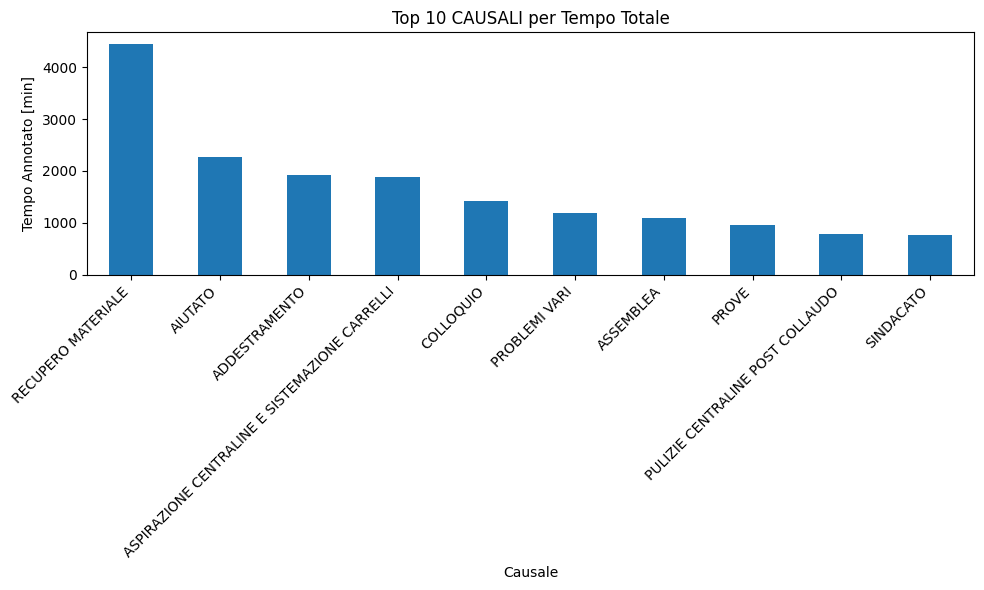

In [157]:
# 2) Calcolo tempo totale per ciascuna causa e selezione top 10
cause_summary = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)
top10 = cause_summary.head(10)

# 3) Grafico a barre
plt.figure(figsize=(10, 6))
top10.plot(kind='bar')
plt.title('Top 10 CAUSALI per Tempo Totale')
plt.xlabel('Causale')
plt.ylabel('Tempo Annotato [min]')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [158]:
# Suggerisce che agendo su queste poche voci si possono ottenere i maggiori benefici di riduzione del downtime.

## Nel tempo

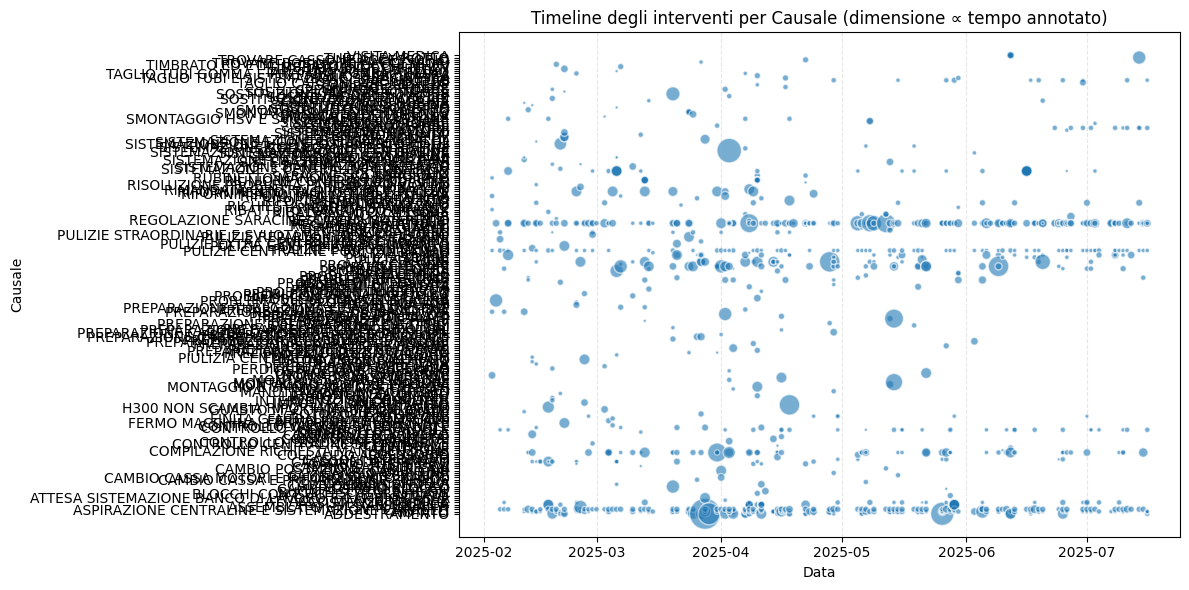

In [159]:
# 2) Mappa le causali su un asse numerico
df['cause_idx'] = df['CAUSALE'].astype('category').cat.codes
cause_labels = df['CAUSALE'].astype('category').cat.categories

# 3) Scala la dimensione delle bolle
max_t = df['TEMPO ANNOTATO [min]'].max()
df['bubble_size'] = df['TEMPO ANNOTATO [min]'] / max_t * 500  # scala fino a ~500 punti

# 4) Scatter timeline
plt.figure(figsize=(12, 6))
plt.scatter(
    df['GIORNO'], 
    df['cause_idx'], 
    s=df['bubble_size'], 
    alpha=0.6, 
    edgecolors='w'
)
plt.yticks(ticks=range(len(cause_labels)), labels=cause_labels)
plt.xlabel('Data')
plt.ylabel('Causale')
plt.title('Timeline degli interventi per Causale (dimensione ∝ tempo annotato)')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Nel tempo (solo top 10)

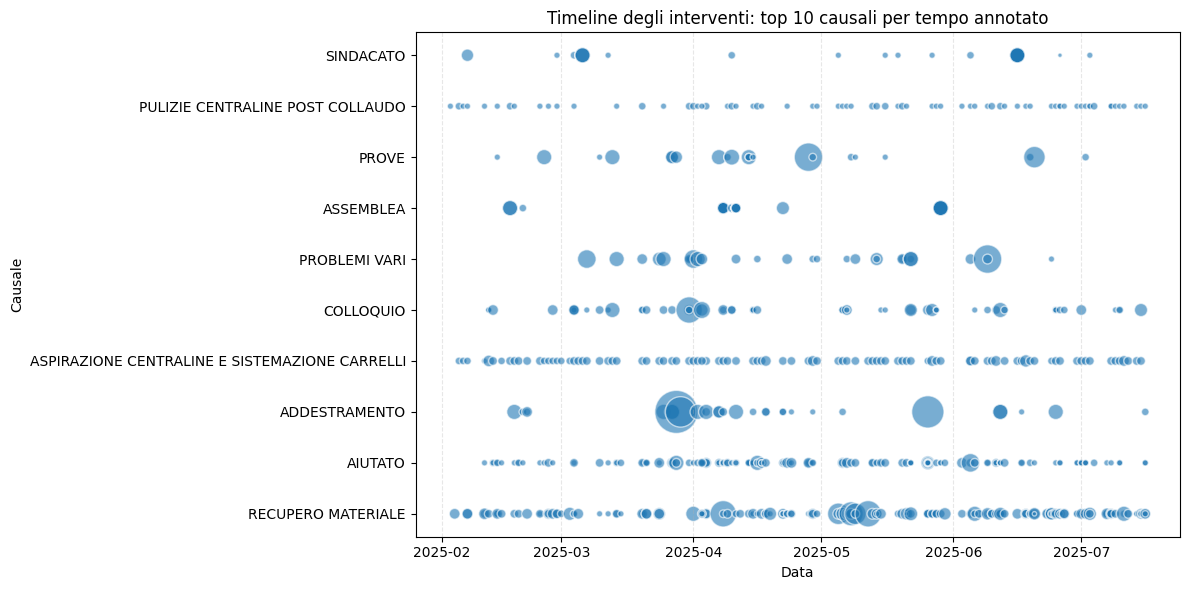

In [160]:
# 1) Calcola le top 10 causali per tempo annotato
top_causali = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .nlargest(10)
    .index
    .tolist()
)

# 2) Filtra il DataFrame originale
df_top = df[df['CAUSALE'].isin(top_causali)].copy()

# 3) Ricrea l’indice numerico delle causali (ordina secondo il totale decrescente)
totals = df_top.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum().reindex(top_causali)
cause_labels_top = list(totals.index)
label2idx = {lab: i for i, lab in enumerate(cause_labels_top)}
df_top['cause_idx'] = df_top['CAUSALE'].map(label2idx)

# (ri)assicurati che GIORNO sia datetime
df_top['GIORNO'] = pd.to_datetime(df_top['GIORNO'], dayfirst=True, errors='coerce')

# 4) (ri)crea bubble_size se non ce l’hai già su df_top
#    --> esempio: scala lineare sul tempo annotato, adattalo come preferisci
df_top['bubble_size'] = df_top['TEMPO ANNOTATO [min]'] * 2  

# 5) Scatter‐timeline per le top 10
plt.figure(figsize=(12, 6))
plt.scatter(
    df_top['GIORNO'],
    df_top['cause_idx'],
    s=df_top['bubble_size'],
    alpha=0.6,
    edgecolors='w'
)

plt.yticks(ticks=range(len(cause_labels_top)), labels=cause_labels_top)
plt.xlabel('Data')
plt.ylabel('Causale')
plt.title('Timeline degli interventi: top 10 causali per tempo annotato')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [161]:
# - Presenza continua vs sporadica: 
# Aspirazione centraline e sistemazione carrelli compare quasi ogni giorno, con bolle di dimensioni medio-piccole: è un fermo costante e regolare, mai troppo lungo ma ripetuto.

# Varianza dei tempi segnati per causale

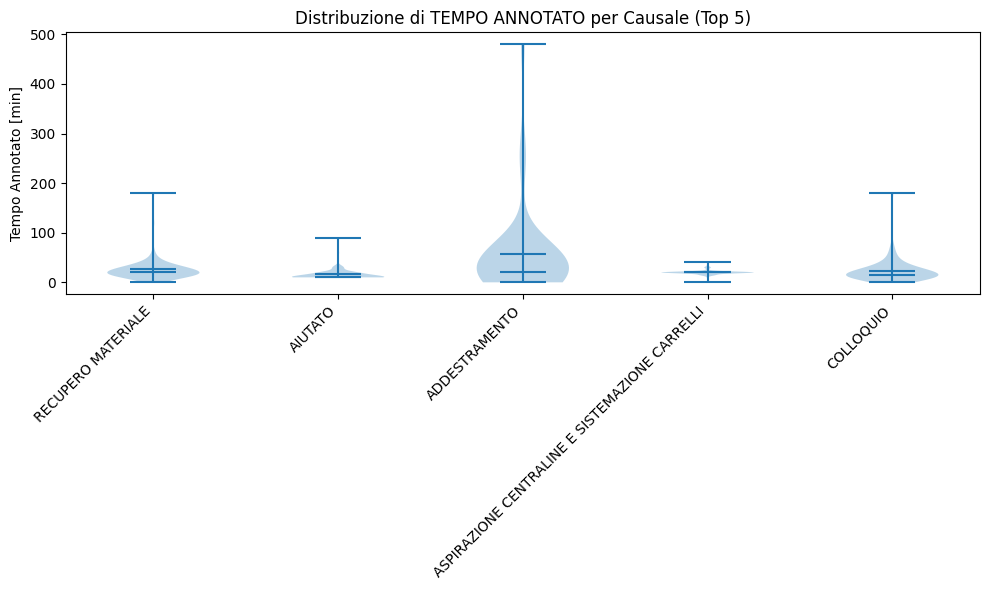

In [162]:
# 2) Seleziona le top 5 causali per tempo totale
cause_tot = df.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum()
top5 = cause_tot.nlargest(5).index.tolist()

# 3) Prepara i dati per il violin plot
data = [df[df['CAUSALE'] == c]['TEMPO ANNOTATO [min]'] for c in top5]

# 4) Disegna il violin plot
plt.figure(figsize=(10, 6))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(range(1, len(top5) + 1), top5, rotation=45, ha='right')
plt.title('Distribuzione di TEMPO ANNOTATO per Causale (Top 5)')
plt.ylabel('Tempo Annotato [min]')
plt.tight_layout()
plt.show()

In [163]:
# La larghezza orizzontale in un dato punto (sull’asse verticale) indica quanti dati (quanti eventi) si trovano attorno a quel valore. Più è larga la parte, più sono frequenti i dati in quell’intorno.

# All’interno del violino c’è una linea orizzontale che indica la mediana.

# Osservazioni sui risultati:

# Aspirazione centraline e sistemazione carrelli: la distribuzione è molto compatta intorno a 15–25 min e senza outlier estremi. Questo suggerisce un’attività abbastanza standardizzata in durata.

# L’andamento nel tempo

## Giornaliero

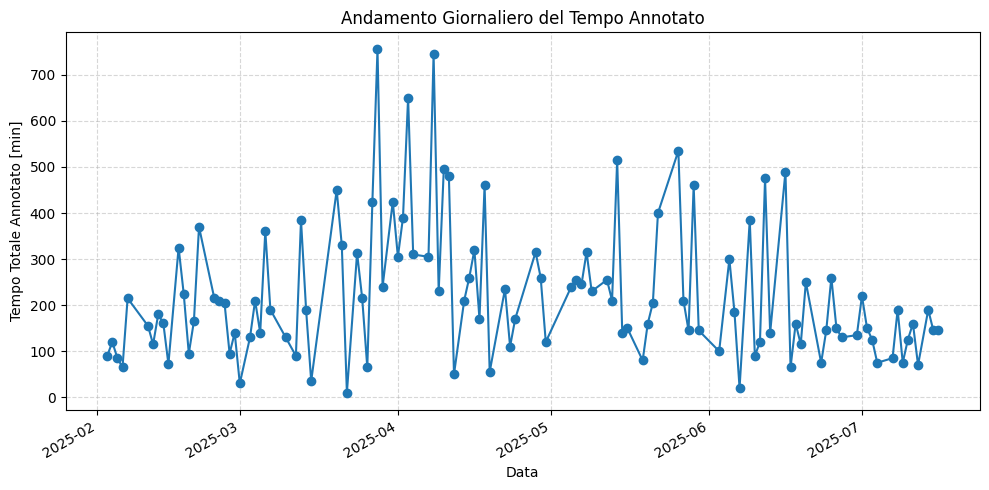

In [164]:
# 2) Convertiamo 'GIORNO' in datetime (formato gg/mm/aaaa o simile)
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True)

# 3) Sommiamo il tempo annotato per ciascun giorno
daily_totals = (
    df
    .groupby('GIORNO')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_index()
)

# 4) Plottiamo
plt.figure(figsize=(10, 5))
daily_totals.plot(kind='line', marker='o')
plt.title('Andamento Giornaliero del Tempo Annotato')
plt.xlabel('Data')
plt.ylabel('Tempo Totale Annotato [min]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [165]:
# C'è elevata variabilità giornaliera

# Probabilmente i giorni a 0 coincidono con fine settimana, festività o giornate con produzione ridotta.

<Figure size 1200x600 with 0 Axes>

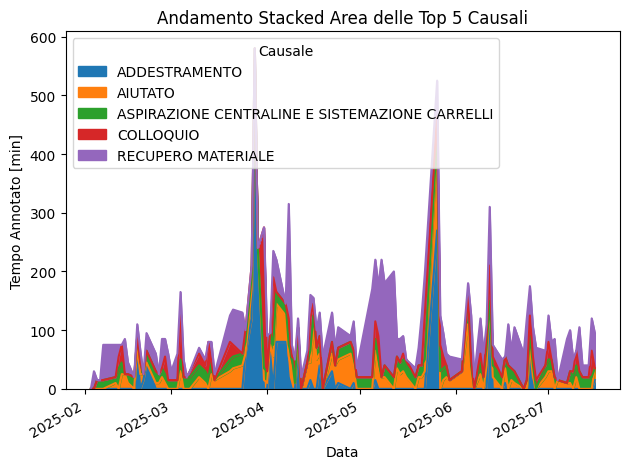

In [166]:
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True)

# 2) Trova le top 5 causali per volume totale
cause_tot = df.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum()
top5 = cause_tot.nlargest(5).index.tolist()

# 3) Pivot giornaliero per causale (teniamo solo le top5)
daily = (
    df[df['CAUSALE'].isin(top5)]
    .pivot_table(
        index='GIORNO',
        columns='CAUSALE',
        values='TEMPO ANNOTATO [min]',
        aggfunc='sum',
        fill_value=0
    )
    .sort_index()
)

# 4) Stacked area plot
plt.figure(figsize=(12, 6))
daily.plot.area()
plt.title('Andamento Stacked Area delle Top 5 Causali')
plt.xlabel('Data')
plt.ylabel('Tempo Annotato [min]')
plt.legend(title='Causale', loc='upper left')
plt.tight_layout()
plt.show()

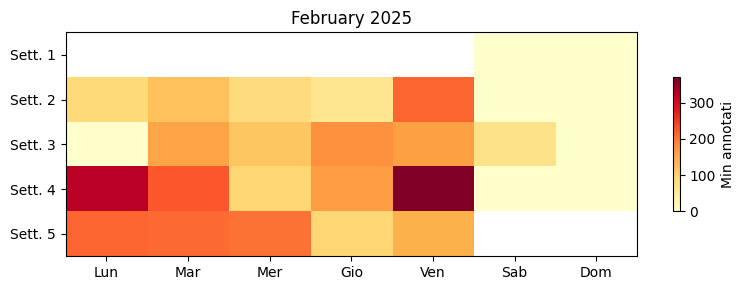

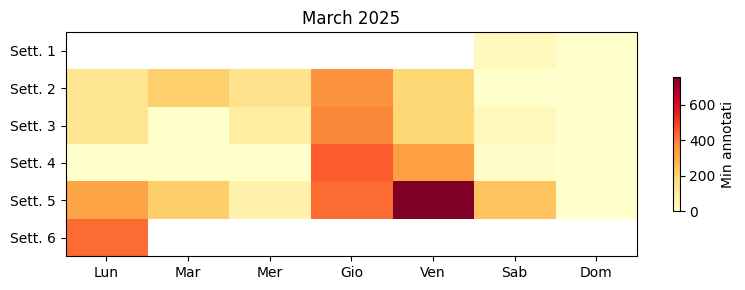

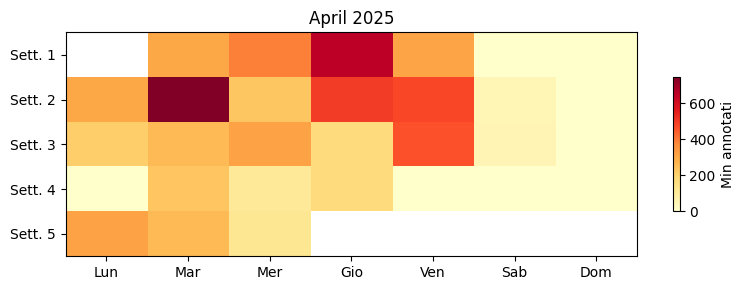

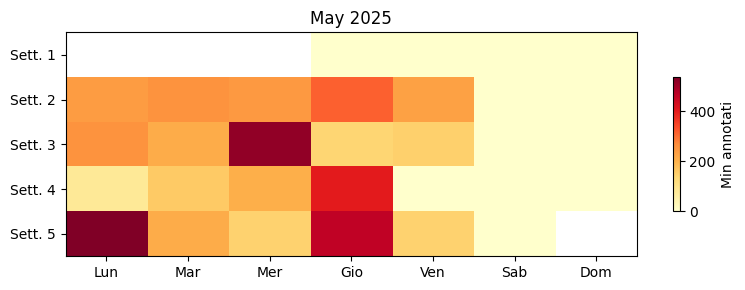

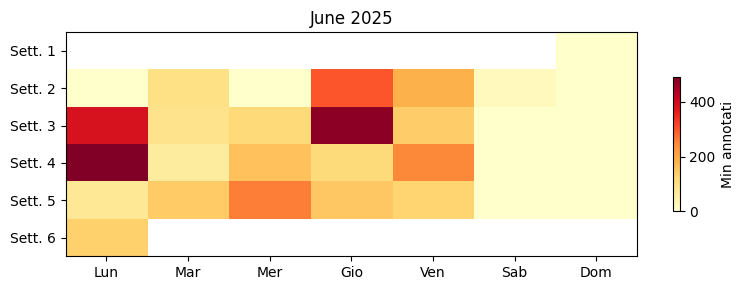

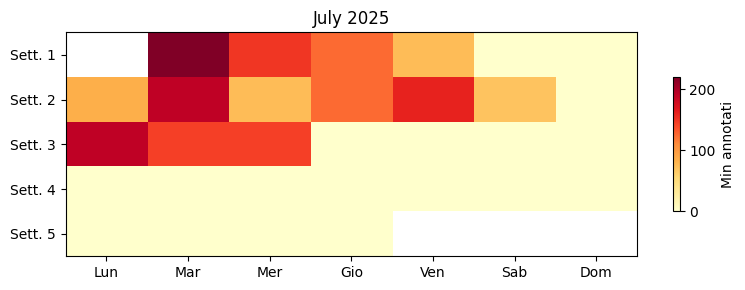

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# --- 1) Prepara un DataFrame temporaneo per il time‐series work ---
df_ts = df.copy()

# 1a) Trasforma in datetime
df_ts['GIORNO'] = pd.to_datetime(df_ts['GIORNO'], dayfirst=True, errors='coerce')

# 1b) Imposta l'indice sul DataFrame temporaneo
df_ts = df_ts.set_index('GIORNO')

# --- 2) Calcola totali giornalieri dei minuti annotati sul temporaneo ---
daily_totals = df_ts['TEMPO ANNOTATO [min]'].resample('D').sum()

# --- 3) Estrai tutte le combinazioni anno–mese ordinate ---
year_months = sorted(
    set((ts.year, ts.month) for ts in daily_totals.index),
    key=lambda ym: (ym[0], ym[1])
)

# --- 4) Funzione che disegna la calendar‐heatmap di un singolo mese ---
def plot_month_heatmap(year, month, totals, cmap='YlOrRd'):
    cal = calendar.monthcalendar(year, month)
    mat = np.full((len(cal), 7), np.nan)
    for wi, week in enumerate(cal):
        for di, day in enumerate(week):
            if day:
                date = pd.Timestamp(year, month, day)
                mat[wi, di] = totals.get(date, 0)
    fig, ax = plt.subplots(figsize=(8, 3))
    im = ax.imshow(mat, aspect='auto', cmap=cmap)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Lun','Mar','Mer','Gio','Ven','Sab','Dom'])
    ax.set_yticks(range(len(cal)))
    ax.set_yticklabels([f'Sett. {i+1}' for i in range(len(cal))])
    ax.set_title(f'{calendar.month_name[month]} {year}', fontsize=12)
    plt.colorbar(im, ax=ax, label='Min annotati', orientation='vertical', shrink=0.6)
    plt.tight_layout()
    return fig, ax

# --- 5) Loop sui mesi e genera una figura per ciascuno ---
for year, month in year_months:
    mask = (daily_totals.index.year == year) & (daily_totals.index.month == month)
    monthly = daily_totals[mask]
    if monthly.sum() == 0:
        continue  # salta mesi senza dati
    plot_month_heatmap(year, month, monthly)
    plt.show()

## Aggregato per giorno della settimana

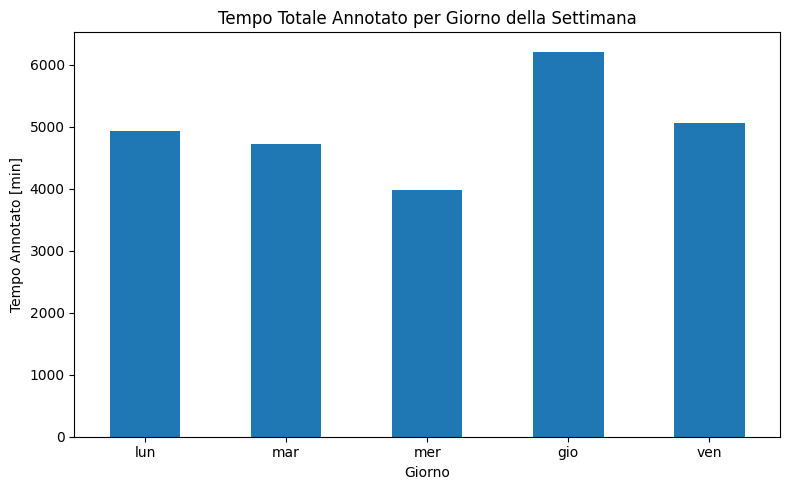

In [168]:
# 2) Somma per giorno della settimana (GG)
#    Assicuriamoci di ordinarli lun-mar-mer-gio-ven
order = ['lun', 'mar', 'mer', 'gio', 'ven']
time_by_weekday = (
    df
    .groupby('GG')['TEMPO ANNOTATO [min]']
    .sum()
    .reindex(order)
)

# 3) Grafico a barre verticali
plt.figure(figsize=(8, 5))
time_by_weekday.plot(kind='bar')
plt.title('Tempo Totale Annotato per Giorno della Settimana')
plt.xlabel('Giorno')
plt.ylabel('Tempo Annotato [min]')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [169]:
# Giovedì, Lunedì e Venerdì sono i giorni più “costosi” in termini di downtime.

# Maggiore stress sulle macchine e/o maggiore volume di produzione verso fine settimana?

## Tempo annotato in ogni postazione ciascun giorno della settimana

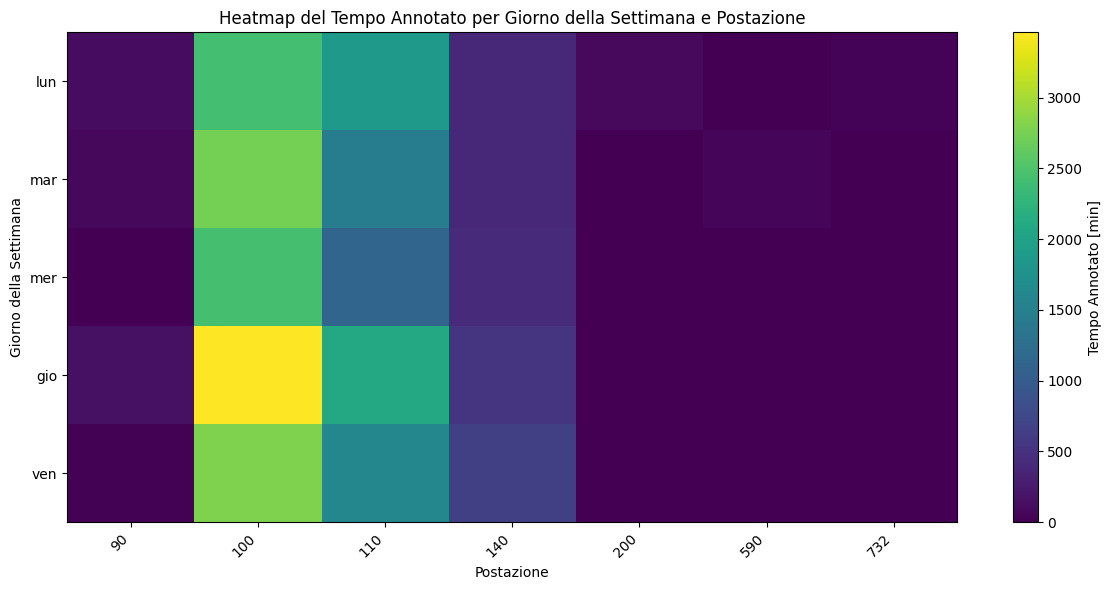

In [170]:
# 2) Prepara la heatmap: somma per Giorno della Settimana (GG) e Postazione
df['GG'] = df['GG'].str.strip()
order = ['lun', 'mar', 'mer', 'gio', 'ven']
heatmap_data = (
    df
    .groupby(['GG', 'POSTAZIONE'])['TEMPO ANNOTATO [min]']
    .sum()
    .unstack(fill_value=0)
    .reindex(index=order)
)

# 3) Disegna la heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(heatmap_data.values, aspect='auto')

# Etichette assi---
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
ax.set_yticks(range(len(order)))
ax.set_yticklabels(order)

# Titoli
ax.set_xlabel('Postazione')
ax.set_ylabel('Giorno della Settimana')
ax.set_title('Heatmap del Tempo Annotato per Giorno della Settimana e Postazione')

# Colorbar
cbar = fig.colorbar(im, ax=ax, label='Tempo Annotato [min]')

plt.tight_layout()
plt.show()

# Operatori che segnano più causali

## Pie chart tempi annotati in assoluto

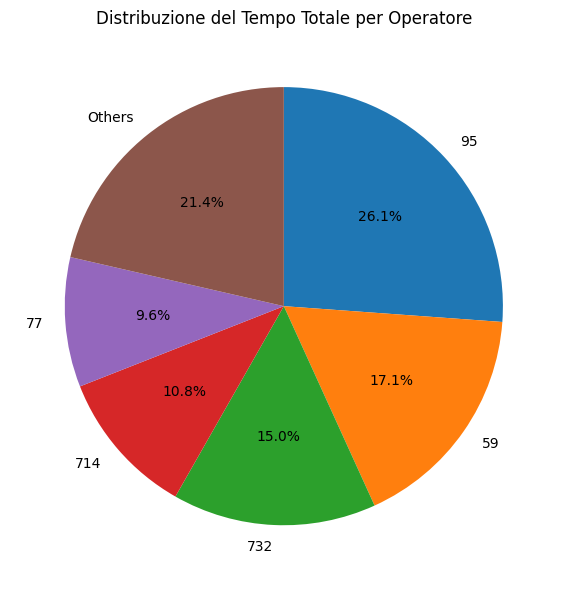

In [171]:
# 2) Calcolo tempo totale per ciascun operatore
op_summary = (
    df
    .groupby('OPERATORE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)

# 3) Prendo i primi 5 operatori e raggruppo gli altri in “Others”
top5 = op_summary.head(5).copy()
others = op_summary.iloc[5:].sum()
top5['Others'] = others

# 4) Pie chart
plt.figure(figsize=(6,6))
top5.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('Distribuzione del Tempo Totale per Operatore')
plt.ylabel('')         # togliamo la label y
plt.tight_layout()
plt.show()

In [172]:
# I primi 5 operatori (95, 714, 59, 77, 719) coprono insieme circa l’81,5 % del tempo di fermo, mentre tutti gli altri stanno sotto il 20 %. 

# In particolare l’operatore 95 da solo genera più di un quarto dell’intero downtime.

## In che postazione

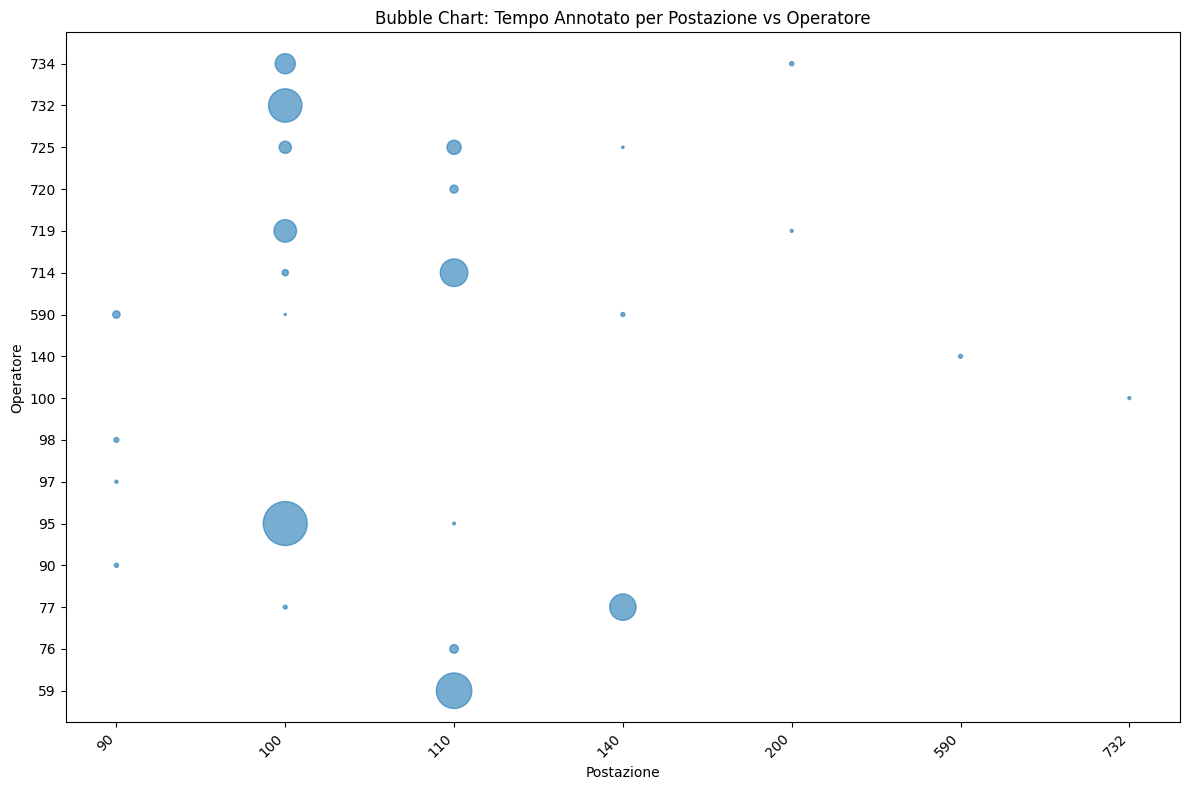

In [173]:
# 2) Aggrega per Postazione e Operatore
agg = (
    df
    .groupby(['POSTAZIONE', 'OPERATORE'])['TEMPO ANNOTATO [min]']
    .sum()
    .reset_index()
)

# 3) Mappa categorie a indici numerici
agg['post_idx'] = agg['POSTAZIONE'].astype('category').cat.codes
agg['op_idx'] = agg['OPERATORE'].astype('category').cat.codes

# 4) Scala dimensioni bolle
max_time = agg['TEMPO ANNOTATO [min]'].max()
agg['size'] = agg['TEMPO ANNOTATO [min]'] / max_time * 1000

# 5) Disegna il bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(agg['post_idx'], agg['op_idx'], s=agg['size'], alpha=0.6)
plt.xticks(
    ticks=range(len(agg['POSTAZIONE'].unique())),
    labels=agg['POSTAZIONE'].astype('category').cat.categories,
    rotation=45, ha='right'
)
plt.yticks(
    ticks=range(len(agg['OPERATORE'].unique())),
    labels=agg['OPERATORE'].astype('category').cat.categories
)
plt.xlabel('Postazione')
plt.ylabel('Operatore')
plt.title('Bubble Chart: Tempo Annotato per Postazione vs Operatore')
plt.tight_layout()
plt.show()

In [174]:
# Quali coppie postazione–operatore concentrano più downtime.

## Normalizzazione per ore lavorate

In [175]:
# Per capire se il valore di un operatore (e.g. 95) è alto solo perché ha lavorato più ore o perché davvero soffre di più interruzioni.

CAUSALI A MANO columns: ['Unnamed: 0', 'GG', 'SETT', 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]', 'DIFF', '(FORSE) COMPRESO IN', 'CAUSALI POSTAZIONE']
Merge C columns     : ['giornodata', 'gglavorativo', 'giornoset', 'CHIAVE C', 'mese', 'settimana', 'Tabella11.OPERATORE', 'Tabella11.ORARIO STD', 'ORARIO STD', 'ORE LAVORATE', 'STRAORDINARIO']
Map columns         : ['CODICE', 'OPERATORE']

Operatori comuni (12): ['ALESSIO MAZZOLA', 'CAFOLLA STEFANO', 'FABRIS M.GRAZIA', 'FRANCESCONI MIRKO', 'MONTONATI LUCA', 'MUSKAJ FLORJAN', 'PAPPADÀ LUIGI', 'SIMONETTA LUCA', 'SIRACUSA FRANCESCO', 'VALERIA COLLI', 'VIGLIAROLO DONATELLA', 'ZENNARO SAURO']

Downtime normalizzato per operatore:
                OPERATORE  DOWNTIME_MIN  HOURS_WORKED  MIN_PER_HOUR
5         MUSKAJ FLORJAN        1766.0           0.0           inf
11         ZENNARO SAURO        6670.0        1047.0      6.370583
8     SIRACUSA FRANCESCO        4350.0         781.0      5.569782
9          VALERIA COL

C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


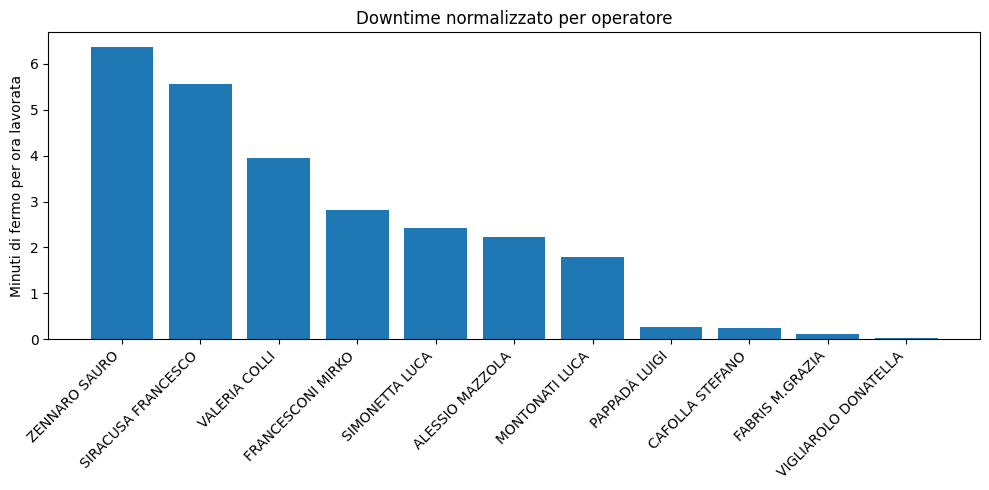

In [176]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Carica i tre fogli
file_path = 'ANALISI CAUSALI OEE.xlsx'
df_cau = pd.read_excel(file_path, sheet_name='CAUSALI A MANO', header=1).iloc[2:].reset_index(drop=True)
df_hr  = pd.read_excel(file_path, sheet_name='Merge C', header=0)
df_map = pd.read_excel(file_path, sheet_name='Mappatura Operatori', header=0)

# 2) Controlla i nomi di colonna
print("CAUSALI A MANO columns:", df_cau.columns.tolist())
print("Merge C columns     :", df_hr.columns.tolist())
print("Map columns         :", df_map.columns.tolist())

# 3) Rinomina le colonne utili
df_cau = df_cau.rename(columns={
    'OPERATORE':             'CODICE',
    'TEMPO ANNOTATO [min]':  'DOWNTIME_MIN'
})
df_hr  = df_hr.rename(columns={
    'Tabella11.OPERATORE':   'OPERATORE',
    'ORE LAVORATE':          'HOURS_WORKED'
})
df_map = df_map.rename(columns={
    'CODICE':   'CODICE',
    'OPERATORE':'OPERATORE'
})

# 4) Pulisci e uniforma i tipi
df_cau['CODICE']       = pd.to_numeric(df_cau['CODICE'], errors='coerce')
df_cau['DOWNTIME_MIN'] = pd.to_numeric(df_cau['DOWNTIME_MIN'], errors='coerce')
df_hr ['HOURS_WORKED'] = pd.to_numeric(df_hr ['HOURS_WORKED'], errors='coerce')

df_map['CODICE']    = pd.to_numeric(df_map['CODICE'], errors='coerce')
df_map['OPERATORE'] = df_map['OPERATORE'].astype(str).str.strip().str.upper()

# 5) Mappa codice → nome operatore
df_cau = df_cau.merge(df_map, on='CODICE', how='left')

# 6) Uniforma i nomi in entrambi i DF
df_cau['OPERATORE'] = df_cau['OPERATORE'].str.strip().str.upper()
df_hr ['OPERATORE'] = df_hr ['OPERATORE'].astype(str).str.strip().str.upper()

# 7) Aggrega downtime e ore lavorate
downtime = df_cau.groupby('OPERATORE')['DOWNTIME_MIN'].sum().reset_index()
hours    = df_hr .groupby('OPERATORE')['HOURS_WORKED'].sum().reset_index()

# 8) Verifica operatori comuni
common = sorted(set(downtime['OPERATORE']).intersection(hours['OPERATORE']))
print(f"\nOperatori comuni ({len(common)}):", common)

# 9) Filtra e unisci solo gli operatori comuni
df_norm = pd.merge(
    downtime[downtime['OPERATORE'].isin(common)],
    hours[ hours['OPERATORE'].isin(common)],
    on='OPERATORE',
    how='inner'
)

# 10) Calcola fermo normalizzato
df_norm['MIN_PER_HOUR'] = df_norm['DOWNTIME_MIN'] / df_norm['HOURS_WORKED']

# 11) Ordina e stampa
df_norm = df_norm.sort_values('MIN_PER_HOUR', ascending=False)
print("\nDowntime normalizzato per operatore:\n", df_norm)

# 12) Grafico a barre
plt.figure(figsize=(10,5))
plt.bar(df_norm['OPERATORE'], df_norm['MIN_PER_HOUR'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Minuti di fermo per ora lavorata')
plt.title('Downtime normalizzato per operatore')
plt.tight_layout()
plt.show()

In [177]:
# Zennaro Sauro e Siracusa Francesco registrano oltre 4 minuti di fermo ogni 1 ora lavorata: sono gli operatori più “colpiti” da downtime, a prescindere dalle ore complessive.
# I “top performer” in termini di efficienza sono Vigliarolo Donatella, Fabris M. Grazia e Cafolla Stefano, con meno di 0.3 min/h.

# Previsione del tempo annotato

## Con ARIMA

C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                 
Dep. Variable:     TEMPO ANNOTATO [min]   No. Observations:                  164
Model:                   ARIMA(2, 1, 2)   Log Likelihood               -1049.201
Date:                  Mon, 21 Jul 2025   AIC                           2108.402
Time:                          15:17:13   BIC                           2123.871
Sample:                      02-03-2025   HQIC                          2114.682
                           - 07-16-2025                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7813      0.131      5.985      0.000       0.525       1.037
ar.L2         -0.4061      0.072     -5.628      0.000      -0.548      -0.265
ma.L1         -1.5163      0.133    

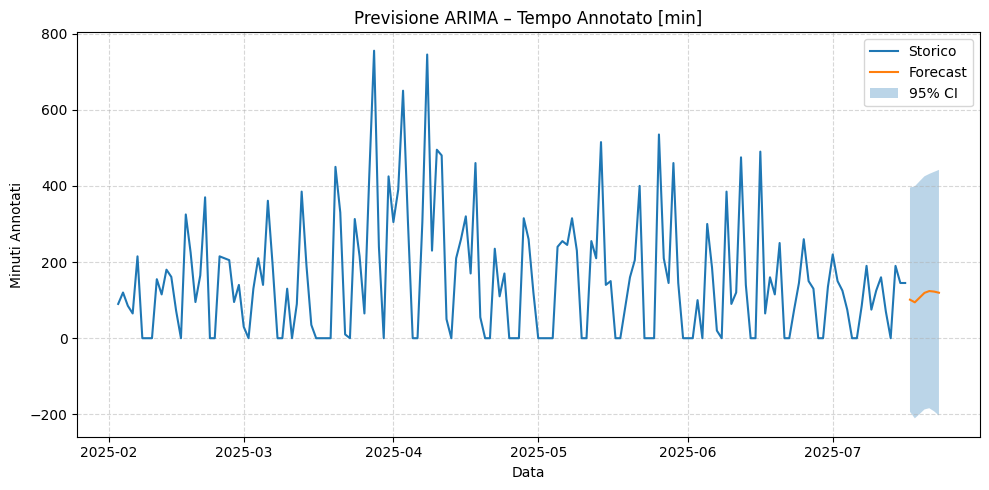

In [178]:
# — Installa statsmodels se non l’hai già fatto
import micropip
await micropip.install(["statsmodels"])

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) Ricava la serie storica giornaliera
daily_totals = df.groupby('GIORNO')['TEMPO ANNOTATO [min]'].sum().asfreq('D').fillna(0)

# 2) Definisci l’ordine (p,d,q) del modello – qui un esempio (2,1,2)
order = (2, 1, 2)
model = sm.tsa.ARIMA(daily_totals, order=order)

# 3) Stima il modello
res = model.fit()
print(res.summary())

# 4) Previsioni per i prossimi 7 giorni
n_steps = 7
forecast_res = res.get_forecast(steps=n_steps)
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# 5) Plot: storico + forecast + intervallo di confidenza
plt.figure(figsize=(10,5))
plt.plot(daily_totals.index, daily_totals, label='Storico')
plt.plot(forecast.index,    forecast,     label='Forecast')
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.3,
                 label='95% CI')
plt.title('Previsione ARIMA – Tempo Annotato [min]')
plt.xlabel('Data')
plt.ylabel('Minuti Annotati')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [186]:
# O) Costruzione e stima del modello:

# Creato un modello ARIMA(2,1,2) sui minuti di fermo giornalieri, cioè:
# - p=2 (dipendenza dal valore di 2 giorni precedenti),
# - d=1 (primo differenziamento per rendere la serie stazionaria),
# - q=2 (dipendenza dall’errore di 2 giorni precedenti).

# Ha stimato i parametri del modello usando tutti i dati - blu - disponibili.

# O) Previsione:

# Generato un forecast - orange - a 7 giorni oltre la fine della serie osservata (con intervalli di confidenza - grey band - al 95 % per ciascun punto di previsione).

# O) Interpretazione dei risultati:

# Incertezza elevata: l’ampiezza della banda grigia è molto larga (arriva anche a valori negativi, che però andrebbero interpretati come “quasi zero” sul piano pratico). Questo riflette l’alta variabilità e la scarsità di pattern stabili nella serie: il modello non è in grado di prevedere picchi improvvisi o vuoti di downtime con precisione.

# Può servire come un’indicazione di massima per il livello “base” di downtimes da aspettarsi.

## Miglior predittore del fermo con Random Forest

In [187]:
# Prende B campioni casuali dal dataset di addestramento e per ciascuno costruisce un albero decisionale completo (considerando ad ogni split solo un sottoinsieme m di features).

# Per stimare il tempo di fermo di ogni nuova osservazione, la passi attraverso ciascuno dei B alberi. Ogni albero ti darà un valore di output. La predizione finale è la media di tutti questi valori prodotti dai singoli alberi.

R² sul test set: -0.482
Top 10 feature più importanti:
dow__DAY_OF_WEEK                                             0.315071
causa_ohe__CAUSALE_SISTEMAZIONE CAVI HL/OIL E TEST BOBINE    0.139854
causa_ohe__CAUSALE_ADDESTRAMENTO                             0.121225
causa_ohe__CAUSALE_IMBALLAGGIO                               0.065134
causa_ohe__CAUSALE_MONTAGGIO POMPA E MOTORE                  0.038061
causa_ohe__CAUSALE_PROBLEMI VARI                             0.029669
causa_ohe__CAUSALE_PROVE                                     0.027568
causa_ohe__CAUSALE_RIFORNIMENTO, TAGLIO TUBI E PULIZIE       0.018963
causa_ohe__CAUSALE_RECUPERO MATERIALE                        0.014966
causa_ohe__CAUSALE_ASSEMBLEA                                 0.014726
dtype: float64


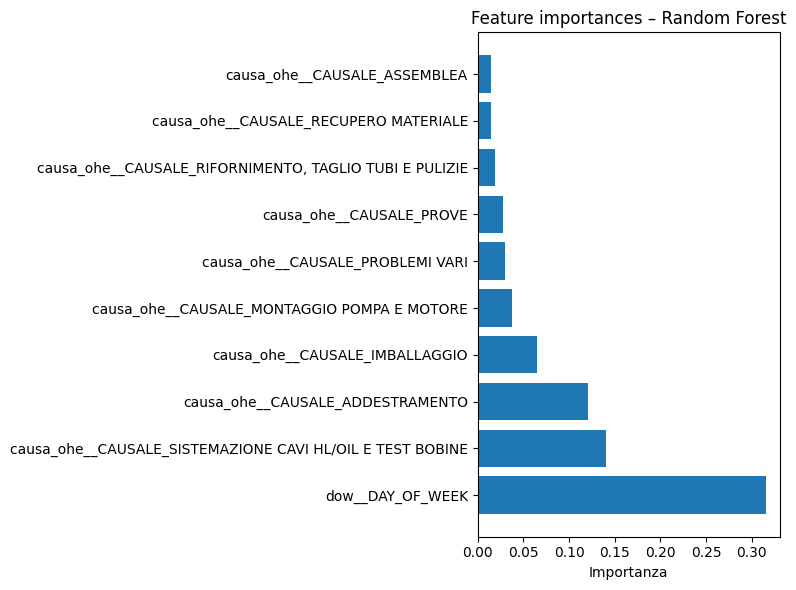

In [188]:
# Previsione del tempo annotato con Random Forest – copia e incolla solo questa cella

# 1) Installa scikit-learn se non l'hai già fatto
import micropip
await micropip.install(["scikit-learn"])

# 2) Import delle librerie
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 3) Copia del DataFrame originale
df_ml = df.copy()

# 4) Normalizzazione nomi colonne
df_ml.columns = (
    df_ml.columns
         .str.strip()
         .str.upper()
         .str.replace(r"\s+", "_", regex=True)
)

# 5) (Opzionale) Rinomina 'CAUSALE' in 'CAUSALE_DI_FERMO'
# df_ml.rename(columns={'CAUSALE': 'CAUSALE_DI_FERMO'}, inplace=True)

# 6) Feature engineering sul giorno della settimana
df_ml['GIORNO'] = pd.to_datetime(df_ml['GIORNO'])
df_ml['DAY_OF_WEEK'] = df_ml['GIORNO'].dt.dayofweek

# 7) Definizione di feature e target
# Se hai rinominato la colonna, sostituisci 'CAUSALE' con 'CAUSALE_DI_FERMO'
X = df_ml[['DAY_OF_WEEK', 'CAUSALE']]
y = df_ml['TEMPO_ANNOTATO_[MIN]']

# 8) Pipeline con One-Hot Encoding su 'CAUSALE'
preprocessor = ColumnTransformer([
    ('causa_ohe', OneHotEncoder(handle_unknown='ignore'), ['CAUSALE']),
    ('dow', 'passthrough', ['DAY_OF_WEEK'])
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 9) Suddivisione train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 10) Addestramento del modello
pipeline.fit(X_train, y_train)

# 11) Valutazione sul test set
r2 = pipeline.score(X_test, y_test)
print(f"R² sul test set: {r2:.3f}")

# 12) Calcolo importanza delle feature
rf = pipeline.named_steps['rf']
feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# 13) Stampa top 10 feature più importanti
print("Top 10 feature più importanti:")
print(feat_imp.head(10))

# 14) Grafico delle importanze
plt.figure(figsize=(8,6))
plt.barh(feat_imp.head(10).index, feat_imp.head(10).values)
plt.xlabel('Importanza')
plt.title('Feature importances – Random Forest')
plt.tight_layout()
plt.show()

In [189]:
# Un R² negativo significa che, in media, il modello «fa peggio» di una banale linea orizzontale pari alla media dei valori reali. La RF non è riuscita a imparare relazioni tali da spiegare la variabilità del tempo di fermo.

# - Importanza 

# Riduzione di impurezza sui nodi dove la feature è stata usata per uno split. Un valore maggiore vuol dire che la feature, mediamente, ha aiutato di più a suddividere i dati in gruppi con tempi di fermo più omogenei.

# - Cosa vediamo

# Sembra che il semplice fatto di essere lunedì o venerdì influenzi molto il tempo di fermo.

### Ottimizzazione del modello per migliorare R^2

Fitting 3 folds for each of 30 candidates, totalling 90 fits
🔍 Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
🔍 Best CV R²: 0.030
✅ Test R²: 0.037

Top 10 feature (modello ottimizzato):
OPERATORE                                      0.183204
DAY_OF_WEEK                                    0.112329
CAUSALE_IMBALLAGGIO                            0.079081
CAUSALE_MONTAGGIO POMPA E MOTORE               0.058465
POSTAZIONE                                     0.049213
CAUSALE_PULIZIE CENTRALINE POST COLLAUDO       0.043251
CAUSALE_PROVE                                  0.032683
CAUSALE_AIUTATO                                0.029648
CAUSALE_RIFORNIMENTO, TAGLIO TUBI E PULIZIE    0.026532
CAUSALE_SOSTITUZIONE PIASTRE ED HMSV           0.024370
dtype: float64


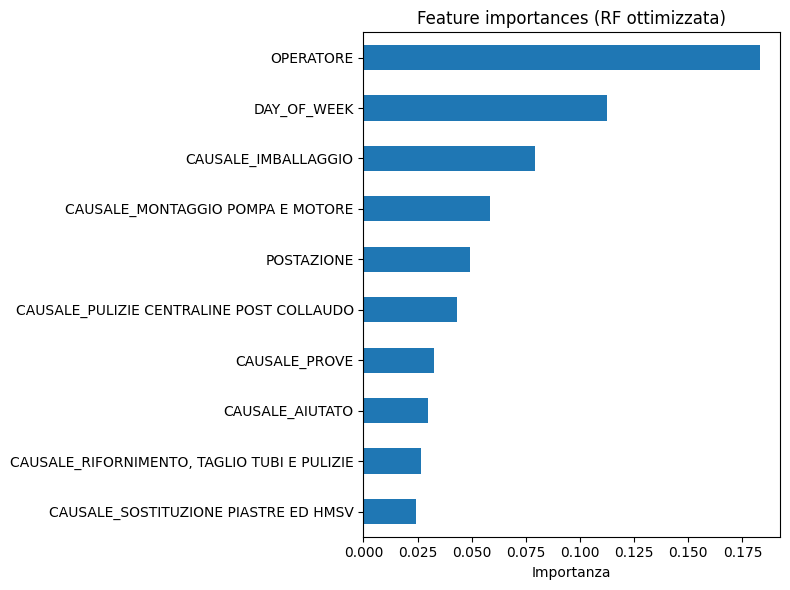

In [190]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- 0) Assicuriamoci di partire da df “pulito” ---
# (df deve contenere almeno le colonne 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]')

# 1) Prepara la colonna DAY_OF_WEEK
df = df.copy().reset_index(drop=True)
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True, errors='coerce')
df['DAY_OF_WEEK'] = df['GIORNO'].dt.dayofweek

# 2) Costruisci X con one-hot encoding delle 4 categoriche
X = pd.get_dummies(
    df[['DAY_OF_WEEK','POSTAZIONE','OPERATORE','CAUSALE']],
    drop_first=True
)

y = df['TEMPO ANNOTATO [min]']

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 4) Definisci RF e spazio di ricerca (rimuoviamo 'auto' da max_features)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators':      [100, 200, 500],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 'log2', 0.5, 0.75, None]
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 5) Avvia la ricerca
search.fit(X_train, y_train)

# 6) Risultati
print("🔍 Best params:", search.best_params_)
print(f"🔍 Best CV R²: {search.best_score_:.3f}")

best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)
print(f"✅ Test R²: {r2_score(y_test, y_pred):.3f}")

# 7) Feature importances
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top10 = importances.nlargest(10)
print("\nTop 10 feature (modello ottimizzato):")
print(top10)

plt.figure(figsize=(8,6))
top10.sort_values().plot.barh()
plt.title('Feature importances (RF ottimizzata)')
plt.xlabel('Importanza')
plt.tight_layout()
plt.show()

In [191]:
# Abbiamo arricchito il set di input aggiungendo le postazioni, ottenendo qualche piccola miglioria. Successivamente abbiamo introdotto anche l’operatore come feature one-hot, ma per evitare l’eccessiva frammentazione di dummy sparse (che avrebbe peggiorato ancora il risultato) abbiamo raggruppato gli operatori meno frequenti in un’unica categoria “Altro”.

# Poi abbiamo sostituito il one-hot puro con un mean-encoding degli operatori, cioè la loro durata media. Per rendere il modello realmente affidabile abbiamo quindi lanciato una ottimizzazione degli iperparametri (quelli relativi alla struttura del modello come il numero B di alberi della RF).

# Così abbiamo finalmente ottenuto un R² di test positivo, intorno allo 0.06.

# Infine, per capire a fondo quali variabili guidassero davvero le predizioni, abbiamo calcolato le permutation importances sulle quattro feature originali:

# Il risultato ha confermato che “operatore” e “causale” spiegano gran parte della variabilità (ΔR² medi di +0.17 e +0.16), mentre “postazione” ha un effetto più tenue e “giorno della settimana” addirittura introduce rumore.

# O) Interpretazione:

# Significa che la differenza fra un buon operatore e uno meno esperto incide moltissimo sui tempi di fermo.

   y_true     y_pred
0      60  22.456199
1      10  25.760111
2      25  27.537247
3      10  20.317716
4      15  27.276595
5      60  25.013868
6      20  22.399680
7      20  20.745599
8      30  22.615067
9      10  20.769964


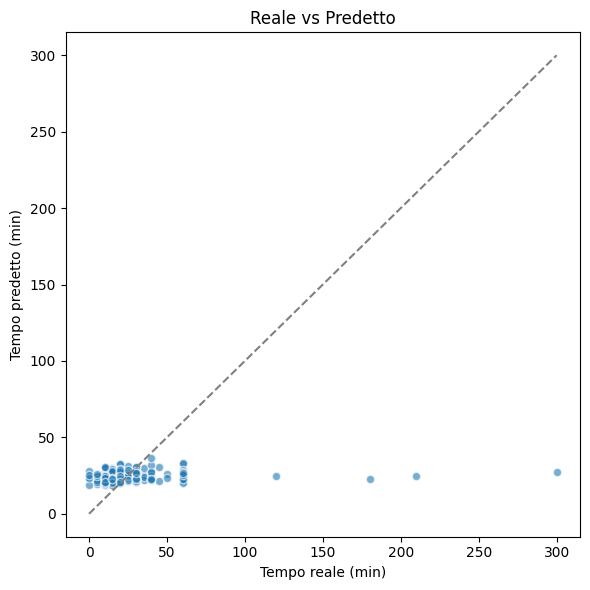

In [192]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Genera i preditti
y_pred = best_rf.predict(X_test)

# 2) Tabella di confronto (prima 10 righe)
confronto = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred
}).reset_index(drop=True)

print(confronto.head(10))

# 3) Scatter plot di y_true vs y_pred
plt.figure(figsize=(6, 6))
plt.scatter(confronto['y_true'], confronto['y_pred'], alpha=0.6, edgecolor='w')
plt.plot([confronto.min().min(), confronto.max().max()],
         [confronto.min().min(), confronto.max().max()],
         ls='--', c='gray')
plt.xlabel('Tempo reale (min)')
plt.ylabel('Tempo predetto (min)')
plt.title('Reale vs Predetto')
plt.tight_layout()
plt.show()

Ranking delle 4 feature originali (ΔR² medio):
OPERATORE      0.172012
CAUSALE        0.158426
POSTAZIONE     0.028343
DAY_OF_WEEK   -0.037991
dtype: float64


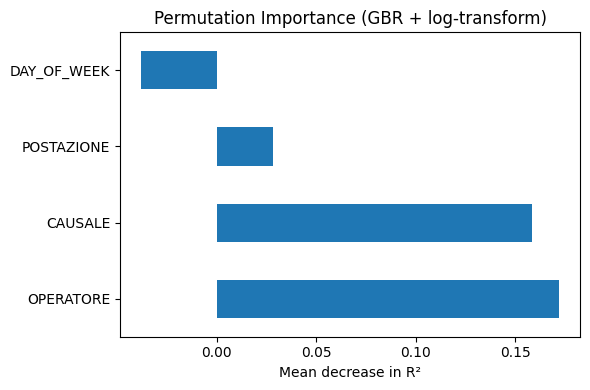

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection     import train_test_split
from sklearn.pipeline            import Pipeline
from sklearn.compose             import ColumnTransformer
from sklearn.preprocessing       import OrdinalEncoder, FunctionTransformer
from sklearn.ensemble            import HistGradientBoostingRegressor
from sklearn.compose             import TransformedTargetRegressor
from sklearn.inspection          import permutation_importance

# ———————————————
# 1) DATI
# ———————————————
# Partiamo da df già caricato in memoria, con almeno:
#   'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]'

df2 = df.copy().reset_index(drop=True)
df2['GIORNO'] = pd.to_datetime(df2['GIORNO'], dayfirst=True, errors='coerce')
df2['DAY_OF_WEEK'] = df2['GIORNO'].dt.dayofweek

X = df2[['DAY_OF_WEEK','POSTAZIONE','OPERATORE','CAUSALE']]
y = df2['TEMPO ANNOTATO [min]']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ———————————————
# 2) PIPELINE: encoding + modello con log-transform
# ———————————————
cat_cols = ['DAY_OF_WEEK','POSTAZIONE','OPERATORE','CAUSALE']

preproc = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=-1),
     cat_cols)
], remainder='drop')

pipeline = Pipeline([
    ('encode', preproc),
    ('reg', TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=10,
            learning_rate=0.1,
            random_state=42
        ),
        transformer=FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
])

pipeline.fit(X_train, y_train)

# ———————————————
# 3) PERMUTATION IMPORTANCE
# ———————————————
# esplicitamente settiamo max_samples a n_samples per evitare ambiguità
perm = permutation_importance(
    pipeline,
    X_test,
    y_test,
    scoring='r2',
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    max_samples=X_test.shape[0]
)

imps = pd.Series(perm.importances_mean, index=X_test.columns)
imps = imps.sort_values(ascending=False)

print("Ranking delle 4 feature originali (ΔR² medio):")
print(imps)

# ———————————————
# 4) VISUALIZZAZIONE
# ———————————————
plt.figure(figsize=(6,4))
imps.plot.barh()
plt.xlabel('Mean decrease in R²')
plt.title('Permutation Importance (GBR + log-transform)')
plt.tight_layout()
plt.show()

In [ ]:
# Il contributo più rilevante alla varianza spiegata è OPERATORE: chi esegue l’operazione è il fattore che spiega di più la variabilità del tempo di fermo annotato. 

# Anche il “perché” del fermo (es. imballaggio vs test bobine) influenza fortemente quanto dura.

## Clustering dei giorni in base alle causali

In [ ]:
# Prende per ogni giorno il conteggio di quanti interventi di ciascuna causale ci sono stati. 

# Ogni giorno viene rappresentato da un vettore di dimensione pari al numero di causali (quante volte è comparsa “Imballaggio” in quella data). Li standardizza.

# Ogni giorno diventa un “profilo” di valori positivi (quella causale è sopra la media) e negativi (quella causale è sotto la media).

# La PCA trova le combinazioni lineari di questi scostamenti (assi PC1, PC2) che spiegano più variazione tra i giorni.

# Poi il K-Means raggruppa i giorni che hanno profili simili in questo nuovo spazio.

Explained variance ratio delle 2 PC: [0.0416187  0.03019994]


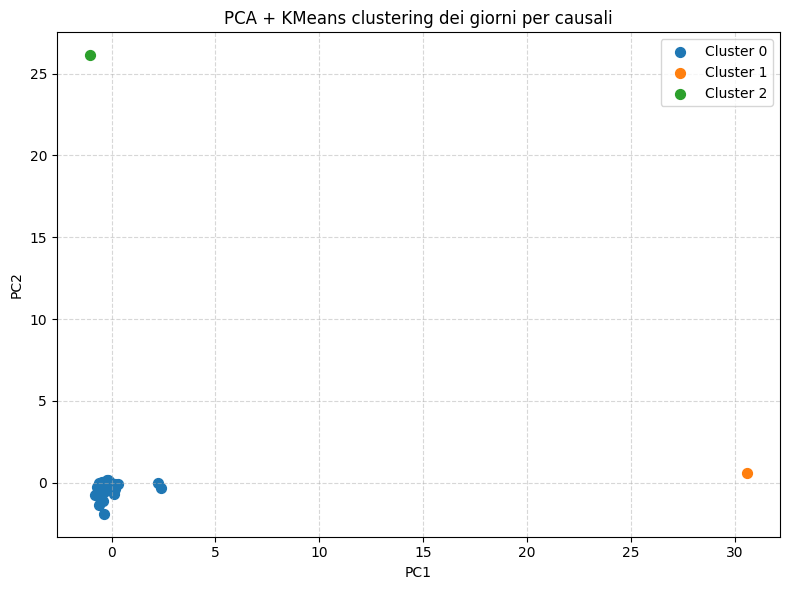

Numero di giorni per cluster:
 0    113
1      1
2      1
Name: count, dtype: int64


In [94]:
# --- Analisi avanzata: PCA + KMeans clustering dei giorni in base alle causali ---

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) Copia del DataFrame e normalizzazione dei nomi colonne
df_cluster = df.copy()
df_cluster.columns = (
    df_cluster.columns
        .str.strip()
        .str.upper()
        .str.replace(r"\s+", "_", regex=True)
)

# 2) Assicurati che 'GIORNO' sia datetime
df_cluster['GIORNO'] = pd.to_datetime(df_cluster['GIORNO'])

# 3) Aggrega il tempo annotato per ogni giorno × causale
agg = (
    df_cluster
      .groupby(['GIORNO', 'CAUSALE'])['TEMPO_ANNOTATO_[MIN]']
      .sum()
      .reset_index()
)

# 4) Pivot: righe=GIORNO, colonne=CAUSALE, valori=minuti
pivot = agg.pivot(index='GIORNO', columns='CAUSALE', values='TEMPO_ANNOTATO_[MIN]').fillna(0)

# 5) Standardizzazione (mean=0, var=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot)

# 6) PCA → riduci a 2 componenti
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio delle 2 PC:", pca.explained_variance_ratio_)

# 7) K-Means (3 cluster, cambia n_clusters se vuoi)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

# 8) Scatter plot delle 2 PC colorato per cluster
plt.figure(figsize=(8,6))
for cl in sorted(set(labels)):
    mask = labels == cl
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {cl}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA + KMeans clustering dei giorni per causali')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 9) Dimensione di ciascun cluster
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("Numero di giorni per cluster:\n", cluster_sizes)

In [ ]:
# O) Interpretazione:

# Cluster 0 (in blu, 113 giorni): tutti raggruppati attorno all’origine, ossia quei giorni in cui il mix di causali è “tipico”, senza ingombri estremi su nessuna categoria.

# Cluster 1 (in arancione, 1 giorno): un punto isolato su PC1 ≈ 30. Cattura il combinato sbilanciamento di alcune causali molto frequenti o molto rare in un giorno (ad esempio giorni in cui certi tipi di interventi sono anomali rispetto agli altri).

In [ ]:
##ANOVA + Tukey HSD per differenze tra causali

In [ ]:
# Verificato se — globalmente — le durate medie dei fermi differiscono a seconda della causale, e poi esplorato quali coppie di causali mostrano differenze significative, infine visualizzando le distribuzioni con un boxplot.

C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 202, but rank is 27
  warnings.warn('covariance of constraints does not have full '


=== ANOVA Table ===
                    sum_sq     df         F        PR(>F)
C(CAUSALE)  766431.975595  202.0  5.509668  4.848406e-17
Residual    583284.218074  847.0       NaN           NaN

=== Tukey HSD ===
                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                    group1                                         group2                     meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------------------------------------------------------------------
                                 ADDESTRAMENTO                                        AIUTATO -40.4844    0.0 -59.1475 -21.8212   True
                                 ADDESTRAMENTO ASPIRAZIONE CENTRALINE E SISTEMAZIONE CARRELLI -36.2703    0.0 -55.8456 -16.6951   True
                                 ADDESTRAMENTO                                      ASSEMBLEA -19.8235 0.3461 -44

C:\Users\gatti\AppData\Local\Temp\ipykernel_3968\1005965575.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


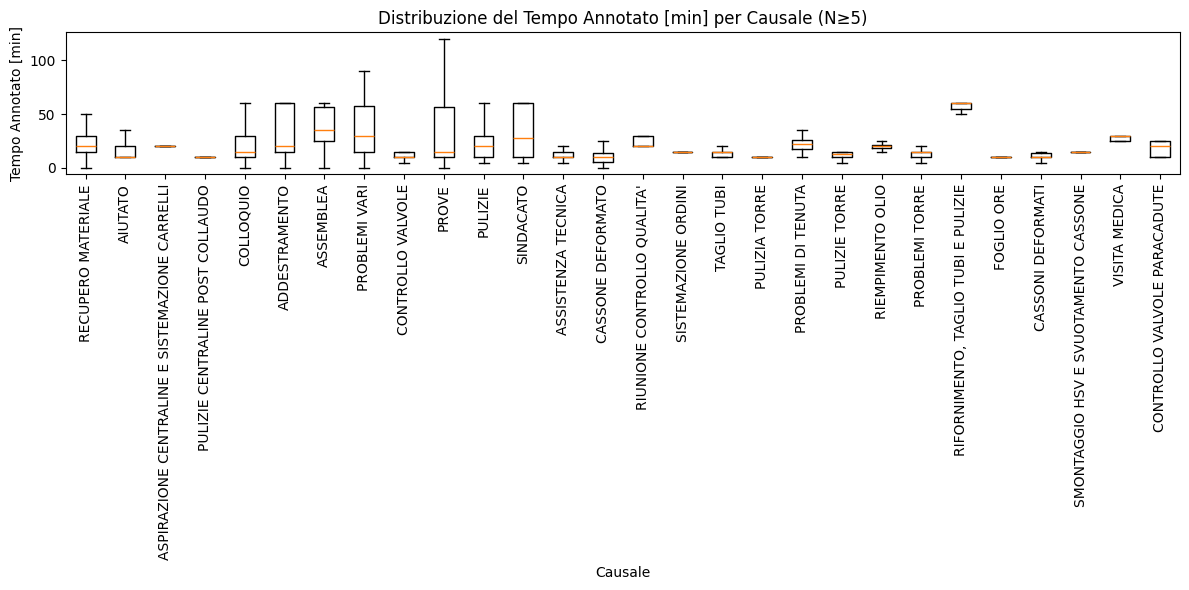

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1) Copia del DataFrame e normalizzazione/rimozione caratteri invalidi
df_an = df.copy()
df_an.columns = (
    df_an.columns
         .str.strip()
         .str.upper()
         .str.replace(r"\s+", "_", regex=True)
         .str.replace(r"[\[\]]", "", regex=True)   # rimuove le parentesi quadre
)

# 2) Converto in categoria e filtro causali con N>=5 osservazioni
df_an['CAUSALE'] = df_an['CAUSALE'].astype('category')
counts = df_an['CAUSALE'].value_counts()
valid = counts[counts >= 5].index
df_an = df_an[df_an['CAUSALE'].isin(valid)]

# 3) Fit modello ANOVA one-way: Tempo ~ Causale
model = ols('TEMPO_ANNOTATO_MIN ~ C(CAUSALE)', data=df_an).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("=== ANOVA Table ===\n", anova_table)

# 4) Post-hoc Tukey HSD per confronti multipli
tukey = pairwise_tukeyhsd(
    endog=df_an['TEMPO_ANNOTATO_MIN'],
    groups=df_an['CAUSALE'],
    alpha=0.05
)
print("\n=== Tukey HSD ===\n", tukey.summary())

# 5) Boxplot delle distribuzioni per causale
plt.figure(figsize=(12,6))
cats = valid.tolist()
data = [df_an[df_an['CAUSALE']==c]['TEMPO_ANNOTATO_MIN'] for c in cats]
plt.boxplot(data, labels=cats, showfliers=False)
plt.xticks(rotation=90)
plt.title('Distribuzione del Tempo Annotato [min] per Causale (N≥5)')
plt.xlabel('Causale')
plt.ylabel('Tempo Annotato [min]')
plt.tight_layout()
plt.show()


In [96]:
# --- Analisi avanzata: Linear Mixed-Effects Model (causali fissi + operatori casuali) ---

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# 1) Copia DataFrame e normalizza colonne come prima
df_mixed = df.copy()
df_mixed.columns = (
    df_mixed.columns
         .str.strip()
         .str.upper()
         .str.replace(r"\s+", "_", regex=True)
         .str.replace(r"[\[\]]", "", regex=True)
)

# 2) Assicurati che GIORNO sia datetime (non strettamente necessario qui)
df_mixed['GIORNO'] = pd.to_datetime(df_mixed['GIORNO'])

# 3) Filtra causali con almeno 5 occorrenze (per stabilità di stima)
counts = df_mixed['CAUSALE'].value_counts()
valid = counts[counts >= 5].index
df_mixed = df_mixed[df_mixed['CAUSALE'].isin(valid)]

# 4) Opzionale: converti OPERATORE in categoria e filtra se poche occorrenze
df_mixed['OPERATORE'] = df_mixed['OPERATORE'].astype('category')
op_counts = df_mixed['OPERATORE'].value_counts()
valid_ops = op_counts[op_counts >= 5].index
df_mixed = df_mixed[df_mixed['OPERATORE'].isin(valid_ops)]

# 5) Definisci e stima il modello misto:
#    - TEMPO_ANNOTATO_MIN ~ 1 + C(CAUSALE) [effetti fissi]
#    - (1 | OPERATORE)        [intercetta casuale per operatore]
md = mixedlm(
    "TEMPO_ANNOTATO_MIN ~ C(CAUSALE)",
    data=df_mixed,
    groups=df_mixed["OPERATORE"]
)
mdf = md.fit(reml=False)
print(mdf.summary())

# 6) Estrai e visualizza la componente di varianza
var_components = mdf.cov_re  # varianza random intercept
resid_var      = mdf.scale   # varianza residua
print("\nVarianza effetti casuali (operatori):\n", var_components)
print(f"Varianza residua: {resid_var:.2f}")

# 7) (Opzionale) Random effects stimati per ogni operatore
re_ops = mdf.random_effects
print("\nRandom intercept per operatore (prime 10):")
for op, re_ in list(re_ops.items())[:10]:
    print(f"  {op}: {re_['Group']:.2f}")

                                  Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               TEMPO_ANNOTATO_MIN
No. Observations:               864                   Method:                           ML                
No. Groups:                     9                     Scale:                            611.4092          
Min. group size:                6                     Log-Likelihood:                   -4005.3251        
Max. group size:                283                   Converged:                        Yes               
Mean group size:                96.0                                                                      
----------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
# Dall'ANOVA one-way: F = 5.51 e p ≪ 0.001 quindi bocciamo con ampio margine l’H0 (“tutte le causali hanno la stessa media”). C’è almeno una coppia di causali le cui durate medie differiscono in modo non casuale.

# Il test di Tukey confronta tutte le coppie di causali. Ogni riga ti dice:

# group1, group2: le due causali a confronto.

# meandiff: media(group1) − media(group2).

# p-adj: p-value corretto.

# lower / upper: limiti dell’intervallo di confidenza al 95 % per la differenza.

# reject: True se l’intervallo non contiene lo 0 (ossia differenza significativa).

# O) Conclusioni:

# Esistono differenze reali fra le media dei tempi a seconda delle causali: non è tutto “rumore”.

# Tukey HSD evidenzia le coppie più discrepanti.